In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from pyqtorch.core.circuit import QuantumCircuit
from pyqtorch.ansatz import AlternateLayerAnsatz
from pyqtorch.embedding import SingleLayerEncoding
from pyqtorch.core.operation import Z, RX

# Generate a Hamiltonian from a graph

In [2]:
n_qubits = 3
n_nodes = n_qubits

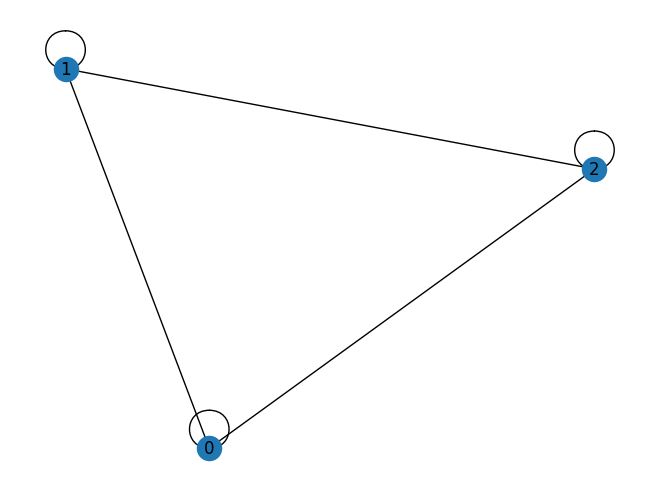

In [3]:
# random

# graph = nx.gnp_random_graph(n_nodes, 1., seed=42)

# or custom one

# graph = nx.Graph()
# graph.add_edge(0, 1, weight=0.5)
# graph.add_edge(1, 2, weight=0.1)
# graph.add_node(0, weight=100.)
# nx.draw(graph, with_labels=True)

# generate a graph from a linear system

A = np.array([[2,2,2],[2,2,2],[2,2,2]])
b = np.array([3,3,3])

def linear_system_to_graph(A, b):
    graph = nx.Graph()
    for idx, el in np.ndenumerate(b):
        graph.add_node(idx[0], weight=el)
    for idx, el in np.ndenumerate(A):
        if el != 0.0:
            graph.add_edge(idx[0], idx[1], weight=el)
            graph.add_edge(idx[0], idx[1], weight=el)
    return graph

graph = linear_system_to_graph(A, b)
nx.draw(graph, with_labels=True)

In [4]:
# # something was planned here?

# def torch_linear_system_to_graph(x, edge_index, edge_weights):
#     graph = nx.Graph()
#     for idx, el in np.ndenumerate(b):
#         graph.add_node(idx[0], weight=el)
#     for idx, el in np.ndenumerate(A):
#         if el != 0.0:
#             graph.add_edge(idx[0], idx[1], weight=el)
#             graph.add_edge(idx[0], idx[1], weight=el)
#     return graph

# graph = torch_linear_system_to_graph(A, b)
# nx.draw(graph, with_labels=True)

In [5]:
# from pyqtorch.matrices import generate_ising_from_graph, sum_N
from pyqtorch.matrices import ZZ, NN, single_N, single_Z

def generate_hamiltonian_from_graph(graph,
                              precomputed_zz=None,
                              type_ising='Z',
                              device='cpu',
                              use_edge_weights=True,
                              use_self_loops=False,
                              use_node_weights=False,
                             ):
    
    """ Given a nx graph, generate the corresponding Ising Hamiltonian in PyQ format. """
    
    # get the number of nodes
    N = graph.number_of_nodes()
    
    # construct the hamiltonian
    H = torch.zeros(2**N, dtype=torch.cdouble).to(device)
    
    # edge weights 
    # go throught the edges and put the ZZ between correspoding nodes
    for edge in graph.edges.data():
        
        # check that the types are integers, otherwise code will run but graph will be incorrect
        assert type(edge[0]) == int
        assert type(edge[1]) == int
        
        # initialize edge weights
        edge_weight = torch.tensor(1, dtype=torch.cdouble)
        if use_edge_weights:
            if len(edge[2]) > 0:
                edge_weight = torch.tensor(edge[2]['weight'],  dtype=torch.cdouble)
        
        # if you already have ZZ(N, edge[0], edge[1], device) computed
        if precomputed_zz is not None:
            if (edge[0], edge[1]) in precomputed_zz[N]:
                key = (edge[0], edge[1])
            else:
                key = (edge[1], edge[0])
            H += edge_weight * precomputed_zz[N][key]
        else:
            # define 
            if type_ising == 'Z':
                if use_self_loops:
                    H += edge_weight * ZZ(N, edge[0], edge[1], device)
                elif edge[0] != edge[1]:
                    H += edge_weight * ZZ(N, edge[0], edge[1], device)
            elif type_ising == 'N':
                if use_self_loops:
                    H += edge_weight * NN(N, edge[0], edge[1], device)
                elif edge[0] != edge[1]:
                    H += edge_weight * NN(N, edge[0], edge[1], device)
            else:
                raise ValueError("'type_ising' must be in ['Z', 'N']")
    
    # node weights
    if use_node_weights:
        for node in graph.nodes.data():
            assert type(node[0]) == int
            if len(node[1]) > 0:
                node_weight = torch.tensor(node[1]['weight'],  dtype=torch.cdouble)
                if type_ising == 'N':
                    H += node_weight * single_N(N, node[0], device)
                elif type_ising == 'Z':
                    H += node_weight * single_Z(N, node[0], device)
                else:
                    raise ValueError("'type_ising' must be in ['Z', 'N']")
           
    return H

graph_hamiltonian_raw = generate_hamiltonian_from_graph(graph, type_ising='Z',
                                                       use_edge_weights=True,
                                                       use_self_loops=True,
                                                       use_node_weights=True)
print(graph_hamiltonian_raw.shape)
graph_hamiltonian = graph_hamiltonian_raw.reshape([2] * n_nodes + [1])
print(graph_hamiltonian.shape)
graph_cost = graph_hamiltonian #1.2*ising_matrix - sum_N(n_nodes)

torch.Size([2])
torch.Size([4])
torch.Size([8])
torch.Size([2, 2, 2, 1])


In [6]:
print(graph_hamiltonian_raw) # these must be the diagonal elements
print(graph_hamiltonian)

tensor([21.+0.j,  7.+0.j,  7.+0.j,  1.+0.j,  7.+0.j,  1.+0.j,  1.+0.j,  3.+0.j],
       dtype=torch.complex128)
tensor([[[[21.+0.j],
          [ 7.+0.j]],

         [[ 7.+0.j],
          [ 1.+0.j]]],


        [[[ 7.+0.j],
          [ 1.+0.j]],

         [[ 1.+0.j],
          [ 3.+0.j]]]], dtype=torch.complex128)


In [7]:
# generate a graph from a linear system

A = np.array([[2,2,2],[2,2,2],[2,2,2]])
b = np.array([3,3,3])

def get_hamiltonian_from_linear_system(A,b, type_ising='Z',
                                       use_edge_weights=True,
                                       use_self_loops=True,
                                       use_node_weights=True):
    
    
    
    graph = linear_system_to_graph(A, b)
    graph_hamiltonian_raw = generate_hamiltonian_from_graph(graph, 
                                                            type_ising='Z',
                                                            use_edge_weights=use_edge_weights,
                                                            use_self_loops=use_self_loops,
                                                            use_node_weights=use_node_weights)
    graph_hamiltonian = graph_hamiltonian_raw.reshape([2] * n_nodes + [1])

    return graph_hamiltonian

graph_hamiltonian_raw = get_hamiltonian_from_linear_system(A,b,
                                                        type_ising='Z',
                                                        use_edge_weights=True,
                                                        use_self_loops=True,
                                                        use_node_weights=True)

In [8]:
graph_hamiltonian_raw

tensor([[[[21.+0.j],
          [ 7.+0.j]],

         [[ 7.+0.j],
          [ 1.+0.j]]],


        [[[ 7.+0.j],
          [ 1.+0.j]],

         [[ 1.+0.j],
          [ 3.+0.j]]]], dtype=torch.complex128)

# Define a model to run the simulation

In [9]:
class MIS(QuantumCircuit):
    """ Construct the circuit of QAOA and compute the expectation value. """
    def __init__(self, n_qubits, n_layers):
        super().__init__(n_qubits)
        self.beta = nn.Parameter(torch.empty(n_layers,))
        self.gamma = nn.Parameter(torch.empty(n_layers,))
        self.reset_parameters()
        
    def reset_parameters(self):
        init.uniform_(self.beta, -2 * np.pi, 2 * np.pi)
        init.uniform_(self.gamma, -2 * np.pi, 2 * np.pi)
        
    def forward(self, return_cost=False):
        state = self.uniform_state()
        for b, g in zip(self.beta, self.gamma):
            state = state * torch.exp(-1j * g * graph_hamiltonian)
            for i in range(self.n_qubits):
                state = RX(b, state, [i], self.n_qubits)
        if return_cost:
            return torch.real(torch.sum(torch.abs(state)**2 * graph_cost))
        else:
            state = state.reshape((2**self.n_qubits,))
            return torch.abs(state)**2

        


In [10]:
class GraphHamiltonianEncoding(QuantumCircuit):
    def __init__(self, n_qubits, n_layers, graph_hamiltonian, parameters=None):
        super().__init__(n_qubits)
        self.gamma = nn.Parameter(torch.empty(n_layers,))
        if parameters == None:
            self.reset_parameters()
        else:
            self.gamma = parameters
    
    def reset_parameters(self):
        init.uniform_(self.gamma, -2 * np.pi, 2 * np.pi)
    
    def forward(self, state):
        print(self.gamma)
        for g in self.gamma:
            state = state * torch.exp(-1j * g * graph_hamiltonian)
        return state

In [12]:
qc = QuantumCircuit(3)
state = qc.uniform_state()
print(state)
gr = GraphHamiltonianEncoding(3,1,graph_hamiltonian, None)
st = gr.forward(state)
# print(gr.gamma)
# print(st)

# def set_parameters(model, theta):
#     """Parameter setter for the neural network."""
#     with torch.no_grad():
#         idx = 0
#         for ps in model.parameters():
#             n = torch.numel(ps)
#             if ps.ndim == 0:
#                 ps[()] = theta[idx : idx + n]
#             else:
#                 ps[:] = theta[idx : idx + n].reshape(ps.size())
#             idx += n

# set_parameters(qr)

tensor([[[[0.3536+0.j],
          [0.3536+0.j]],

         [[0.3536+0.j],
          [0.3536+0.j]]],


        [[[0.3536+0.j],
          [0.3536+0.j]],

         [[0.3536+0.j],
          [0.3536+0.j]]]], dtype=torch.complex128)
Parameter containing:
tensor([5.2433], requires_grad=True)


In [139]:
class Model(QuantumCircuit):
    """ Construct the circuit, embed the data x and compute the expectation value. """
    def __init__(self, n_qubits, n_layers, return_cost):
        super().__init__(n_qubits)
        self.ansatz1 = AlternateLayerAnsatz(n_qubits, n_layers) # hardware-efficient
#         self.embedding = SingleLayerEncoding(n_qubits)
        self.embedding = GraphHamiltonianEncoding(n_qubits,1,graph_hamiltonian)
        self.ansatz2 = AlternateLayerAnsatz(n_qubits, n_layers)
        self.return_cost=return_cost
    def reset_parameters(self):
        init.uniform_(self.beta, -2 * np.pi, 2 * np.pi)
        init.uniform_(self.gamma, -2 * np.pi, 2 * np.pi)
    
    def forward(self, state):
#         batch_size = len(x)
#         state = self.init_state()
        state = self.ansatz1(state)
#         print(state.shape)
        state = self.embedding(state)
#         print(state.shape)
        state = self.ansatz2(state)
        
        if self.return_cost:
            return torch.real(torch.sum(torch.abs(state)**2 * graph_cost))
        else:
            list_meas = []
            def measure_operators(state, qubit):
                new_state = Z(state, [qubit], self.n_qubits)
                state = state.reshape((2**self.n_qubits,))
                new_state = new_state.reshape((2**self.n_qubits,))
                print("----")
                print(new_state.shape)
                print(state.shape)
                print(torch.conj(state).shape)
#                 print(torch.conj(state) * new_state)
#                 return torch.real(torch.sum(torch.conj(state) * new_state, axis=0))
                return torch.real(torch.dot(torch.conj(state) , new_state))

            for i in range(0, self.n_qubits):
                list_meas.append(measure_operators(state, i))
            return list_meas
#             return functorch.vmap(measure_operators)(torch.arange(0, self.n_qubits))

In [140]:
qc = QuantumCircuit(3)
state = qc.uniform_state()
print(state)

tensor([[[[0.3536+0.j],
          [0.3536+0.j]],

         [[0.3536+0.j],
          [0.3536+0.j]]],


        [[[0.3536+0.j],
          [0.3536+0.j]],

         [[0.3536+0.j],
          [0.3536+0.j]]]], dtype=torch.complex128)


In [141]:
print(state)
mc = Model(3,1, False)
mc.forward(state)

tensor([[[[0.3536+0.j],
          [0.3536+0.j]],

         [[0.3536+0.j],
          [0.3536+0.j]]],


        [[[0.3536+0.j],
          [0.3536+0.j]],

         [[0.3536+0.j],
          [0.3536+0.j]]]], dtype=torch.complex128)
Parameter containing:
tensor([5.9344], requires_grad=True)
----
torch.Size([8])
torch.Size([8])
torch.Size([8])
----
torch.Size([8])
torch.Size([8])
torch.Size([8])
----
torch.Size([8])
torch.Size([8])
torch.Size([8])


[tensor(-0.0565, dtype=torch.float64, grad_fn=<SelectBackward0>),
 tensor(-0.0617, dtype=torch.float64, grad_fn=<SelectBackward0>),
 tensor(0.5499, dtype=torch.float64, grad_fn=<SelectBackward0>)]

In [142]:
%%timeit -n 10000 -r 10
# won't update the result just time it 
n_layers = 1
g = nn.Parameter(torch.tensor([0.3 for _ in range(n_layers)]))
exp = torch.exp(-1j * g * graph_hamiltonian)
# print(exp.shape)

12.1 µs ± 978 ns per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


In [143]:
n_layers = 1
g = nn.Parameter(torch.tensor([0.5 for _ in range(n_layers)]))
exp = torch.exp(-1j * g * graph_hamiltonian)

In [144]:
print(exp)

tensor([[[[-0.4755+0.8797j],
          [-0.9365+0.3508j]],

         [[-0.9365+0.3508j],
          [ 0.8776-0.4794j]]],


        [[[-0.9365+0.3508j],
          [ 0.8776-0.4794j]],

         [[ 0.8776-0.4794j],
          [ 0.0707-0.9975j]]]], dtype=torch.complex128, grad_fn=<ExpBackward0>)


Encode the the graph into a Hamiltonian and embed in a quantum state.

In [145]:
n_layers = 1
parameters = nn.Parameter(torch.tensor([0.1 for _ in range(n_layers)]))
# print(parameters)
# parameters = nn.Parameter(torch.reshape(parameters, (n_layers,)))
print(parameters)
# parameters = None
model = GraphHamiltonianEncoding(n_qubits, n_layers=n_layers, graph_hamiltonian=graph_hamiltonian, parameters=parameters)
qc = QuantumCircuit(n_qubits)
state = qc.uniform_state()
print(state)
state = model(state)
print(state)

Parameter containing:
tensor([0.1000], requires_grad=True)
tensor([[[[0.3536+0.j],
          [0.3536+0.j]],

         [[0.3536+0.j],
          [0.3536+0.j]]],


        [[[0.3536+0.j],
          [0.3536+0.j]],

         [[0.3536+0.j],
          [0.3536+0.j]]]], dtype=torch.complex128)
Parameter containing:
tensor([0.1000], requires_grad=True)
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)


In [146]:
class Model(QuantumCircuit):
    """ Construct the circuit, embed the data x and compute the expectation value. """
    def __init__(self, n_qubits, n_layers, return_cost):
        super().__init__(n_qubits)
        self.ansatz1 = AlternateLayerAnsatz(n_qubits, n_layers) # hardware-efficient
        self.embedding = SingleLayerEncoding(n_qubits)
        self.ansatz2 = AlternateLayerAnsatz(n_qubits, n_layers)

    def reset_parameters(self):
        init.uniform_(self.beta, -2 * np.pi, 2 * np.pi)
        init.uniform_(self.gamma, -2 * np.pi, 2 * np.pi)
    
    def forward(self, x, edge_index, edge_attr):
        batch_size = len(x)
        state = self.init_state(batch_size)
        state = self.ansatz1(state)
        state = self.embedding(state, x)
        state = self.ansatz2(state)
        if return_cost:
            return torch.real(torch.sum(torch.abs(state)**2 * graph_cost))
        else:
            new_state = Z(state, [0], self.n_qubits)
            state = state.reshape((2**self.n_qubits, batch_size))
            new_state = new_state.reshape((2**self.n_qubits, batch_size))
            return torch.real(torch.sum(torch.conj(state) * new_state, axis=0))

In [150]:
model = MIS(n_nodes, 20)
# model = Model(n_nodes, 20, return_cost=True)

optimizer = torch.optim.Adam(model.parameters(), lr=.02)
epochs = 500

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = model(True)
    loss.backward()
    optimizer.step()
    print(state.shape)
    print(state)
    print(f"Epoch {epoch+1} | Loss {loss}")

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 1 | Loss 4.638127841036779
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 2 | Loss 12.895929036150054
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 25 | Loss 1.4034622355776991
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 26 | Loss 1.4516467162472275
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_f

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 52 | Loss 1.0270110920267403
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 53 | Loss 1.0185232195046214
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_f

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 78 | Loss 1.001260588428452
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 79 | Loss 1.0016365693496472
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 104 | Loss 1.0001459676886353
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 105 | Loss 1.0000683472567553
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 130 | Loss 1.0000058449020173
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 131 | Loss 1.0000076282009158
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 156 | Loss 0.9999997093217724
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 157 | Loss 0.999999844902302
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 183 | Loss 0.9999999548869619
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 184 | Loss 0.9999988149570124
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 209 | Loss 1.0000000926625123
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 210 | Loss 0.9999997386492728
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 234 | Loss 0.9999993274876986
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 235 | Loss 0.9999996660689908
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 259 | Loss 1.0000000697667344
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 260 | Loss 1.0000001204771085
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 285 | Loss 0.9999997496972575
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 286 | Loss 0.9999995823409957
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad

tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 311 | Loss 0.9999994001452431
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 312 | Loss 0.9999995785285789
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 337 | Loss 0.9999997851611437
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 338 | Loss 0.9999997101763138
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 364 | Loss 0.999999140431057
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 365 | Loss 0.99999959152906
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 391 | Loss 0.9999995268695704
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 392 | Loss 0.9999998694300029
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 417 | Loss 1.000000305421072
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 418 | Loss 0.9999995108077826
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 443 | Loss 0.9999999269425436
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 444 | Loss 0.9999998477210272
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 469 | Loss 1.0000001749897898
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 470 | Loss 0.9999995881086973
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 494 | Loss 0.9999990797291796
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 495 | Loss 0.9999996806805608
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad

In [149]:
prob = model()
print(prob)
mis = torch.argmax(prob)
print(mis.item())
# print(format(mis, '010b'))
"{0:b}".format(mis.item())

tensor([1.2917e-12, 1.1824e-12, 1.1824e-12, 3.3333e-01, 1.1824e-12, 3.3333e-01,
        3.3333e-01, 1.3743e-12], dtype=torch.float64, grad_fn=<PowBackward0>)
6


'110'